## Dependencies

In [1]:
import glob
import warnings
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, SpatialDropout1D, Concatenate, Add, Average
from googleqa_utilityscript import *
from googleqa_map_utilityscript import *
from script_lr_schedulers import WarmUpLearningRateScheduler
from transformers import BertConfig, BertTokenizer, TFBertModel


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
MODULE_BASE_PATH = '/kaggle/input/bert-base-cased-huggingface/bert-base-cased'
MODULE_PATH = MODULE_BASE_PATH + '/bert-base-cased-tf_model.h5'
VOCAB_PATH = MODULE_BASE_PATH + '/bert-base-cased-vocab.txt'
CONF_PATH = MODULE_BASE_PATH + '/bert-base-cased-config.json'

k_fold = pd.read_csv('/kaggle/input/googleqa-mldataset/5-fold.csv')
N_FOLDS = 3

print('Samples: %s' % len(k_fold))
display(k_fold.head())

Samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

# Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']
text_features_question = ['question_title', 'question_body']
text_features_answer = ['question_title', 'answer']

# Model parameters

In [5]:
EPOCHS = 8
BATCH_SIZE = 6
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
N_CLASS_QUESTION = len(question_target_cols)
N_CLASS_ANSWER = len(answer_target_cols)
ES_PATIENCE = 1
MAX_SEQUENCE_LENGTH = 512
MAX_LENGTH_TITLE = 30
MAX_LENGTH_QUESTION = 479
MAX_LENGTH_ANSWER = 479
LR_WARMUP_EPOCHS = 2

# Model

In [6]:
module_config = BertConfig.from_pretrained(CONF_PATH)
module_config.output_hidden_states=False

def model_fn():
    input_word_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_question')
    input_masks_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_question')
    segment_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_question')

    input_word_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_answer')
    input_masks_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_answer')
    segment_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_answer')

    module_model = TFBertModel.from_pretrained(MODULE_PATH, config=module_config)
    sequence_output_question, pooled_output_question = module_model([input_word_ids_question, input_masks_question, segment_ids_question])
    sequence_output_answer, pooled_output_answer = module_model([input_word_ids_answer, input_masks_answer, segment_ids_answer])
    
    x_question = GlobalAveragePooling1D()(sequence_output_question)
    x_question = Dropout(0.2)(x_question)
    output_question = Dense(N_CLASS_QUESTION, kernel_initializer='glorot_uniform', activation="sigmoid", name="outputquestion")(x_question)
    
    x_answer = GlobalAveragePooling1D()(sequence_output_answer)
    x_answer = Dropout(0.2)(x_answer)
    output_answer = Dense(N_CLASS_ANSWER, kernel_initializer='glorot_uniform', activation="sigmoid", name="output_answer")(x_answer)
    
    output = Concatenate()([output_question, output_answer])

    model = Model(inputs=[input_word_ids_question, input_masks_question, segment_ids_question, 
                          input_word_ids_answer, input_masks_answer, segment_ids_answer], outputs=output)

    return model

# Train model

In [7]:
tokenizer = BertTokenizer.from_pretrained(VOCAB_PATH, do_lower_case=False)

history_list = []
metric_list = []
category_metric_list = []
target_cols_preds = [col+'_pred' for col in target_cols]

for n_fold in range(N_FOLDS):
    ### Data
    train = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation']
    
    ### Create features
    # Train features
    X_train = compute_input_arays_2(train, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                    MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                + compute_input_arays_2(train, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                        MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
    Y_train = train[target_cols].values

    # Validation features
    X_valid = compute_input_arays_2(validation, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                    MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                + compute_input_arays_2(validation, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                        MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
    Y_valid = validation[target_cols].values

    # Train model
    model_path = '/kaggle/working/model_fold_%d' % (n_fold+1)
    spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                           validation_data=(X_valid, Y_valid), 
                                           model_path=model_path, 
                                           monitor='val_loss', mode='min', 
                                           patience=ES_PATIENCE, checkpoint=True)
    WARMUP_BATCHES = LR_WARMUP_EPOCHS * len(train) // BATCH_SIZE
    warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

    callback_list = [spearmanCallback, warmup_lr]
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model = model_fn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid), 
                        callbacks=callback_list, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights('/kaggle/working/model_fold_%d_last_epoch.h5' % (n_fold+1))
    
    ### Evaluation - Label metrics
    model.load_weights(model_path+'.h5')
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_valid)
    metric_list.append(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))
    
    ### Evaluation - Category metrics
    for col in target_cols_preds:
        train[col] = 0
        validation[col] = 0

    train[target_cols_preds] = preds_train
    validation[target_cols_preds] = preds_val
    category_metric_list.append(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

Train on 4864 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.3718 val_spearman-rho: 0.3440
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 1014s - loss: 0.4409 - val_loss: 0.3789
Epoch 2/8
spearman-rho: 0.4463 val_spearman-rho: 0.3870
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 962s - loss: 0.3796 - val_loss: 0.3700
Epoch 3/8
spearman-rho: 0.5005 val_spearman-rho: 0.3991
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 961s - loss: 0.3638 - val_loss: 0.3685
Epoch 4/8
spearman-rho: 0.5515 val_spearman-rho: 0.3951
Epoch 00003: early stopping
4864/4864 - 960s - loss: 0.3492 - val_loss: 0.3733
Train on 4864 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.3716 val_spearman-rho: 0.3355
Saved model weights at "/kaggle/working/model_fold_2.h5"
4864/4864 - 1014s - loss: 0.4516 - val_loss: 0.3801
Epoch 2/8
spearman-rho: 0.4435 val_spearman-rho: 0.3735
Saved model weights at "/kaggle/working/model_fold_2.h5

## Model loss graph

Fold: 0


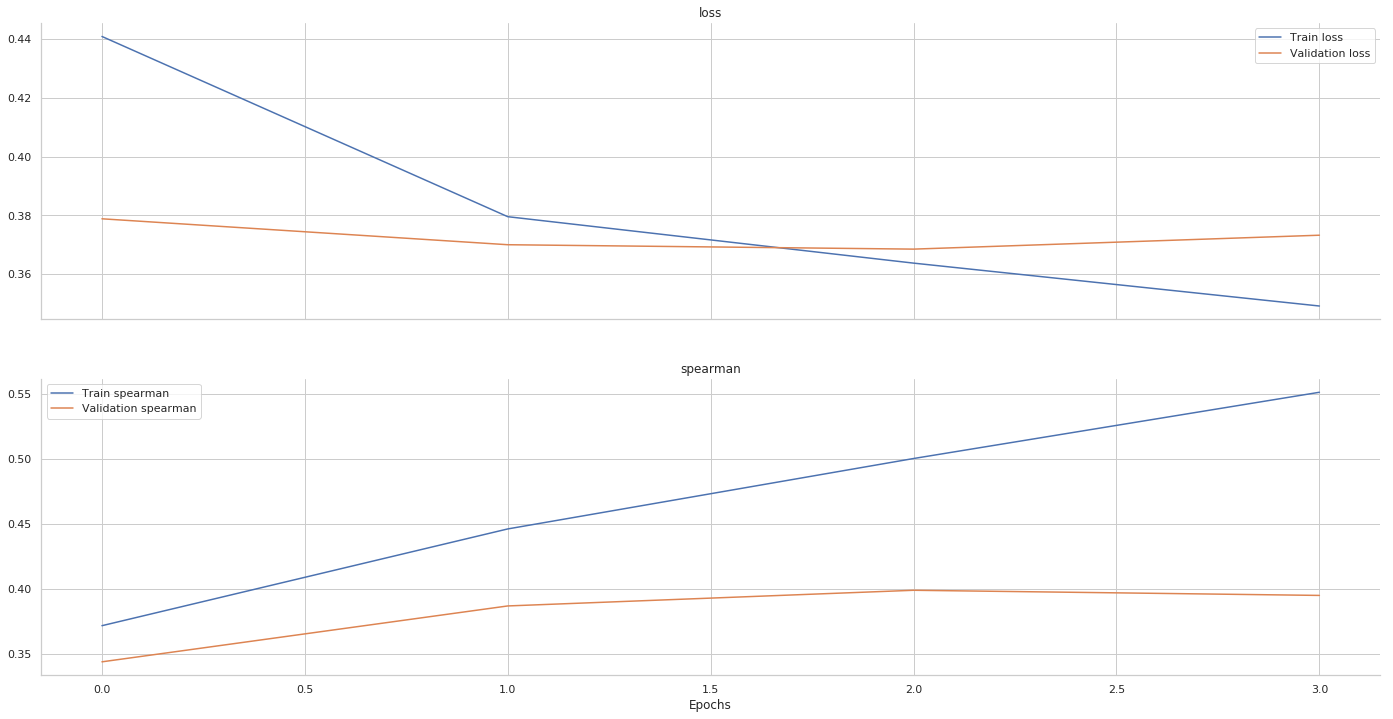

Fold: 1


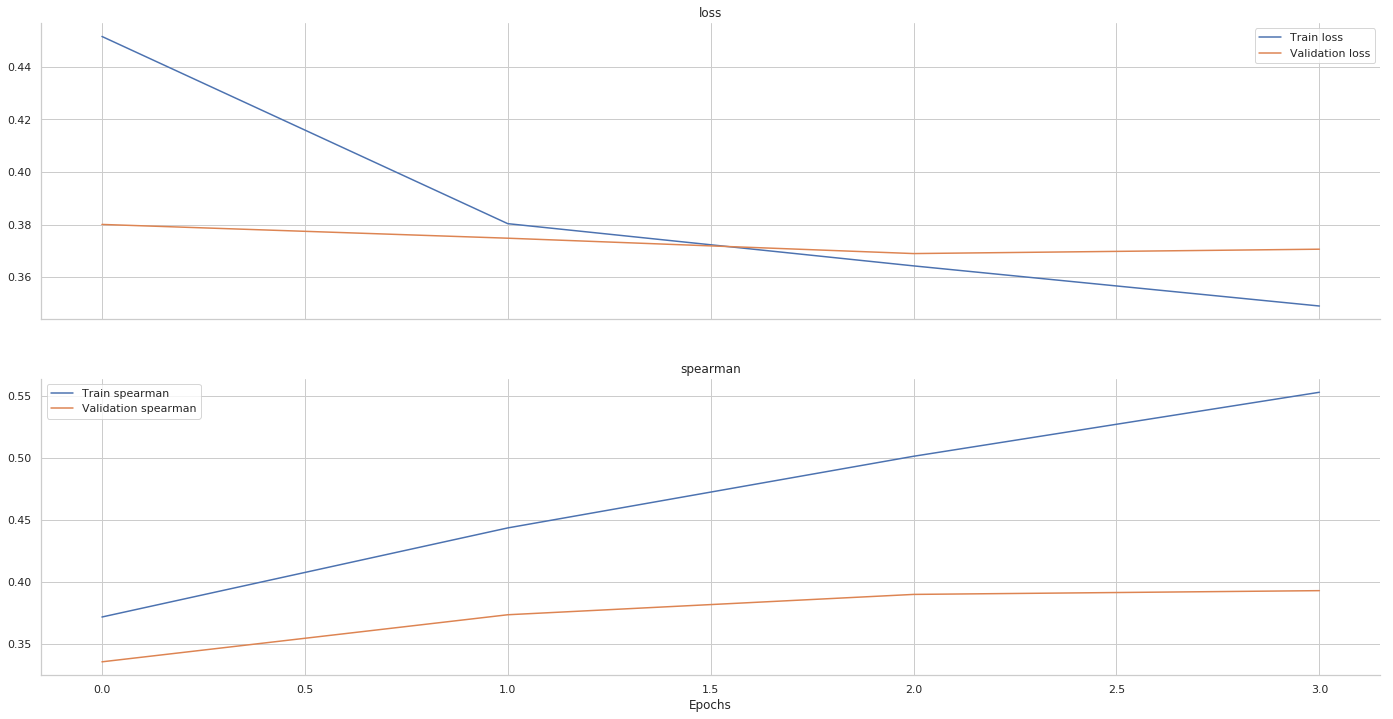

Fold: 2


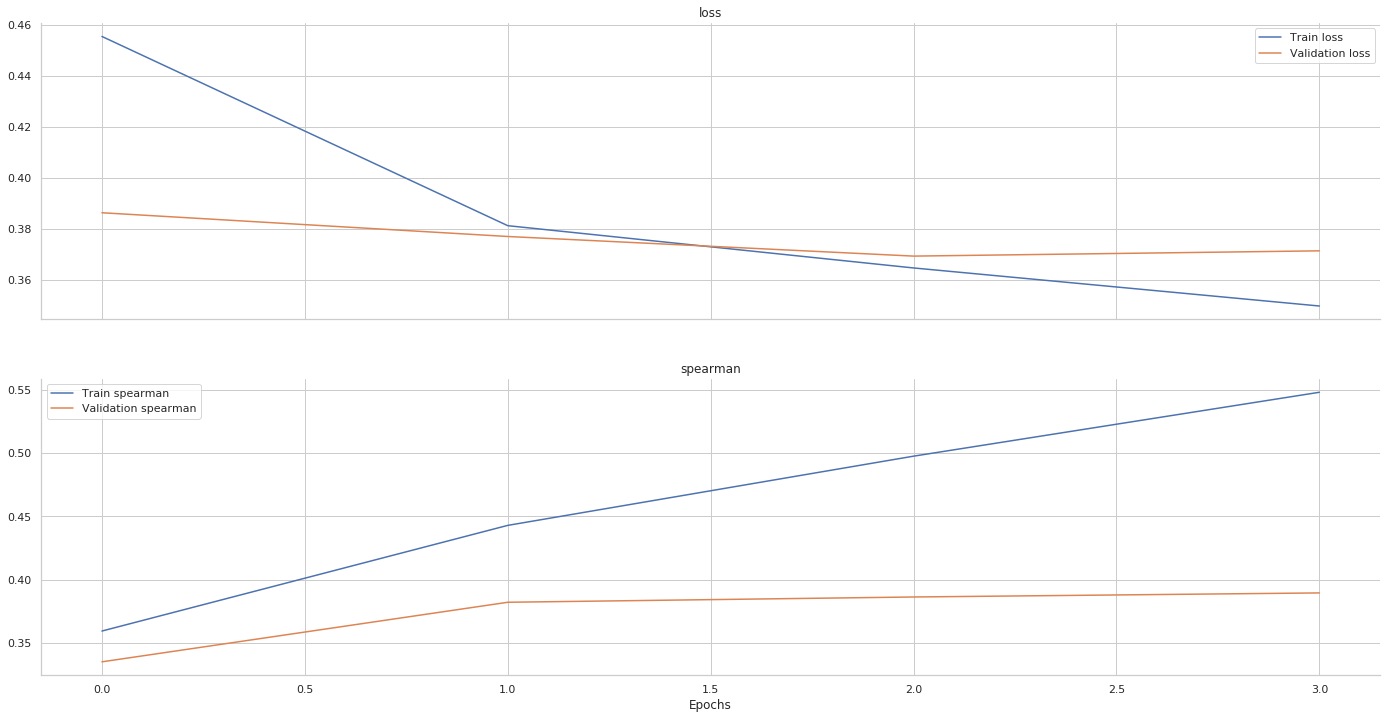

In [8]:
for n_fold in range(N_FOLDS):
    print('Fold: %d' % n_fold)
    sns.set(style="whitegrid")
    plot_metrics(history_list[n_fold], metric_list=['loss', 'spearman'])

# Evaluation

In [9]:
metrics_df = metric_list[0][['Label', 'Train', 'Validation']].copy()
metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    metrics_df_idx = metric_list[n_fold][['Train', 'Validation']].copy()
    metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    metrics_df = pd.concat([metrics_df, metrics_df_idx], axis=1)

metrics_df['Train'] = 0
metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    metrics_df['Train'] += metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    metrics_df['Validation'] += metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS

metrics_df['Var'] = metrics_df['Train'] - metrics_df['Validation']
display(metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,Averaged,0.5,0.399,0.501,0.39,0.498,0.386,0.499667,0.391667,0.108
1,Question averaged,0.513,0.423,0.511,0.417,0.511,0.412,0.511667,0.417333,0.0943333
2,Answer averaged,0.472,0.343,0.479,0.326,0.467,0.327,0.472667,0.332,0.140667
3,question_asker_intent_understanding,0.465,0.373,0.448,0.367,0.471,0.292,0.461333,0.344,0.117333
4,question_body_critical,0.72,0.643,0.71,0.675,0.737,0.651,0.722333,0.656333,0.066
5,question_conversational,0.461,0.42,0.463,0.386,0.465,0.42,0.463,0.408667,0.0543333
6,question_expect_short_answer,0.487,0.317,0.507,0.254,0.48,0.206,0.491333,0.259,0.232333
7,question_fact_seeking,0.522,0.408,0.54,0.343,0.551,0.374,0.537667,0.375,0.162667
8,question_has_commonly_accepted_answer,0.567,0.438,0.563,0.429,0.574,0.418,0.568,0.428333,0.139667
9,question_interestingness_others,0.433,0.315,0.423,0.305,0.421,0.31,0.425667,0.31,0.115667


## By category

In [10]:
category_metrics_df = category_metric_list[0][['Label', 'Train', 'Validation']].copy()
category_metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    category_metrics_df_idx = category_metric_list[n_fold][['Train', 'Validation']].copy()
    category_metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    category_metrics_df = pd.concat([category_metrics_df, category_metrics_df_idx], axis=1)
    
category_metrics_df['Train'] = 0
category_metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    category_metrics_df['Train'] += category_metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    category_metrics_df['Validation'] += category_metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS
    
category_metrics_df['Var'] = category_metrics_df['Train'] - category_metrics_df['Validation']
display(category_metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,LIFE_ARTS,0.537,0.433,0.54,0.403,0.529,0.427,0.535333,0.421,0.114333
1,SCIENCE,0.516,0.42,0.533,0.363,0.53,0.384,0.526333,0.389,0.137333
2,CULTURE,0.539,0.424,0.517,0.399,0.467,0.343,0.507667,0.388667,0.119
3,STACKOVERFLOW,0.382,0.265,0.386,0.278,0.514,0.387,0.427333,0.31,0.117333
4,TECHNOLOGY,0.467,0.353,0.471,0.362,0.389,0.267,0.442333,0.327333,0.115
